In [1]:
#Import Libraries
import tensorflow as tf
import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import datetime
import time


import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.utils.vis_utils import plot_model
import random
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# %matplotlib inline

/Users/astasik/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


# Load and prepare the data

In [2]:
X_load = np.load('data/X.npy')
Y_load = np.load('data/Y.npy')

n_hidden=100

In [3]:
def create_batch(X, Y, n_hidden=150):
    n_sets = X.shape[0]
    len_data = X.shape[-1]

    if n_sets == 1:
        n_set = 0
    else:
        n_set = np.random.randint(0, n_sets, 1)
    
    if n_hidden>len_data:
        raise Exception('Data set to short')
    random_start_point = np.random.randint(0, len_data-n_hidden)
    
    x = X[n_set, random_start_point:random_start_point+n_hidden]
    y = Y[n_set, random_start_point:random_start_point+n_hidden]
    return x,y

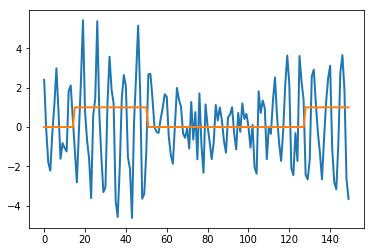

In [4]:
x,y = create_batch(X_load, Y_load, n_hidden=150)

plt.plot(x, lw=2)
plt.plot(y, lw=2)

In [5]:
n_batches = 1000

X = np.zeros((n_batches, n_hidden, 1))
Y = np.zeros((n_batches, n_hidden, 2))

for i in range(n_batches):
    x,y = create_batch(X_load, Y_load, n_hidden=n_hidden)
    res = tf.one_hot(y, depth=2)
    with tf.Session() as sess:
        y = (sess.run(res))
        
    X[i] = np.reshape(x, (x.shape[0], -1))
    Y[i] = y#np.reshape(y, (y.shape[0], -1))

In [6]:
train_input = X[:900]
train_output = Y[:900]

test_input = X[900:]
test_output = Y[900:]

In [7]:
n_dim = 1
input_shape = (None,n_dim)
batch_size = n_hidden

keras.backend.clear_session()
inputs = keras.layers.Input(shape=input_shape)

x = keras.layers.LSTM(25, activation='tanh', return_sequences=True)(inputs)
predictions = keras.layers.Dense(2, activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
model.compile(loss=['categorical_crossentropy'],
              optimizer=keras.optimizers.Adam())


print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 25)          2700      
_________________________________________________________________
dense_1 (Dense)              (None, None, 2)           52        
Total params: 2,752
Trainable params: 2,752
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
epochs = 100

history = model.fit(train_input, train_output, batch_size=batch_size, epochs=epochs,
                    verbose=True, validation_data=(test_input, test_output))


save_dir = 'models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
t = time.strftime("%Y%m%d-%H:%M:%S")
path = os.path.join(save_dir, t+'.h5')  
model.save(path)

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 2ms/step - loss: 0.6815 - val_loss: 0.6653
Epoch 2/100
900/900 [==============================] - 1s 848us/step - loss: 0.6508 - val_loss: 0.6279
Epoch 3/100
900/900 [==============================] - 1s 858us/step - loss: 0.6032 - val_loss: 0.5629
Epoch 4/100
900/900 [==============================] - 1s 835us/step - loss: 0.5088 - val_loss: 0.4118
Epoch 5/100
900/900 [==============================] - 1s 829us/step - loss: 0.3865 - val_loss: 0.3657
Epoch 6/100
900/900 [==============================] - 1s 776us/step - loss: 0.3411 - val_loss: 0.3303
Epoch 7/100
900/900 [==============================] - 1s 850us/step - loss: 0.3091 - val_loss: 0.3033
Epoch 8/100
900/900 [==============================] - 1s 770us/step - loss: 0.2831 - val_loss: 0.2769
Epoch 9/100
900/900 [==============================] - 1s 819us/step - loss: 0.2625 - val_loss: 0.2592
Epoch 10/100
900/900 [=======

900/900 [==============================] - 1s 850us/step - loss: 0.0813 - val_loss: 0.0915
Epoch 80/100
900/900 [==============================] - 1s 819us/step - loss: 0.0814 - val_loss: 0.0912
Epoch 81/100
900/900 [==============================] - 1s 842us/step - loss: 0.0812 - val_loss: 0.0906
Epoch 82/100
900/900 [==============================] - 1s 814us/step - loss: 0.0807 - val_loss: 0.0905
Epoch 83/100
900/900 [==============================] - 1s 828us/step - loss: 0.0802 - val_loss: 0.0922
Epoch 84/100
900/900 [==============================] - 1s 839us/step - loss: 0.0799 - val_loss: 0.0901
Epoch 85/100
900/900 [==============================] - 1s 819us/step - loss: 0.0802 - val_loss: 0.0897
Epoch 86/100
900/900 [==============================] - 1s 835us/step - loss: 0.0806 - val_loss: 0.0893
Epoch 87/100
900/900 [==============================] - 1s 850us/step - loss: 0.0797 - val_loss: 0.0897
Epoch 88/100
900/900 [==============================] - 1s 850us/step - loss:

In [28]:
res.shape

(100, 100, 2)

In [11]:
res = model.predict(test_input)

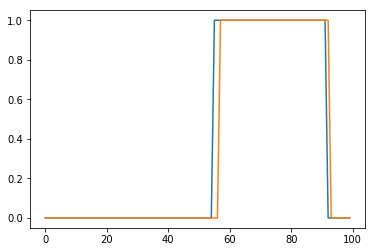

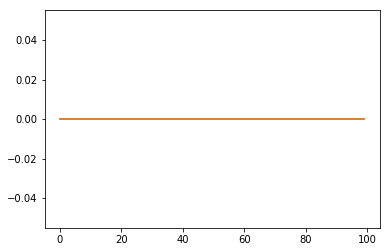

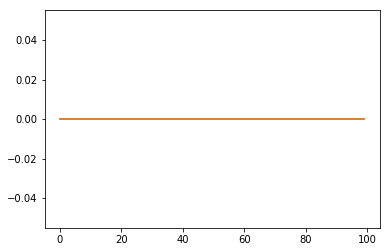

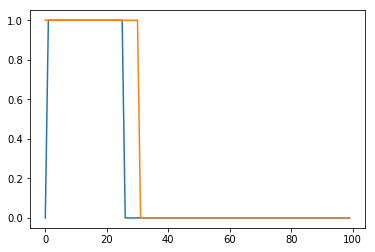

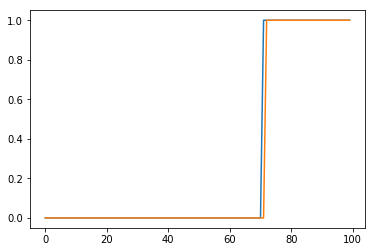

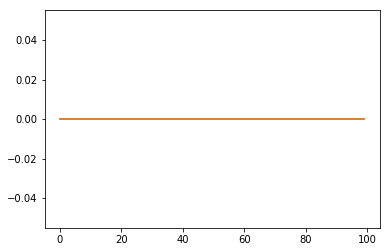

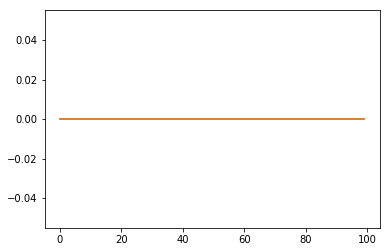

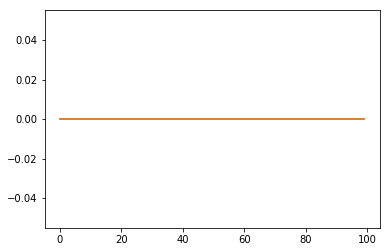

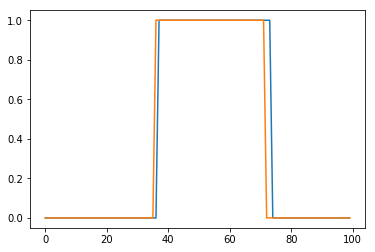

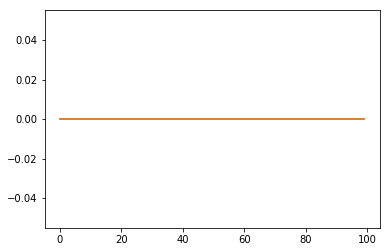

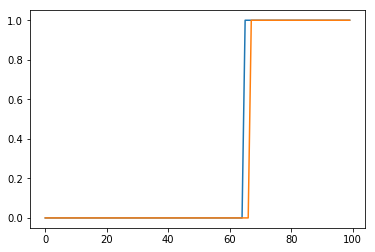

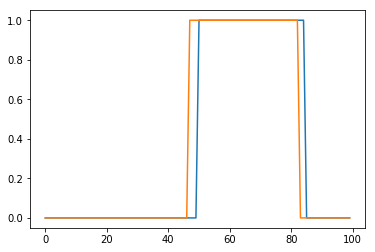

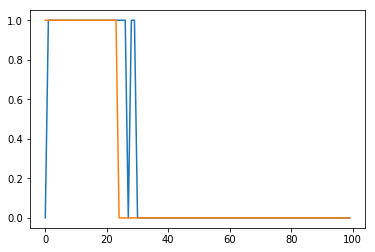

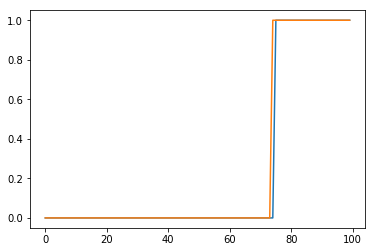

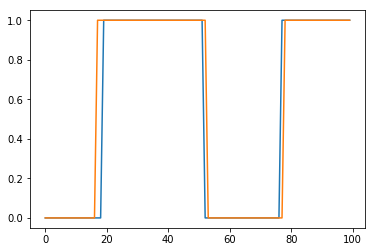

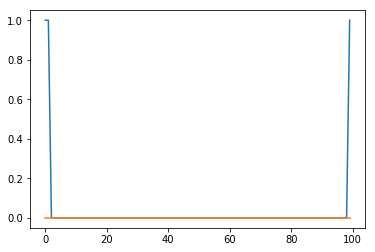

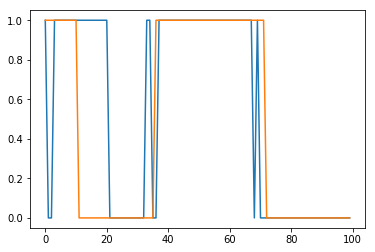

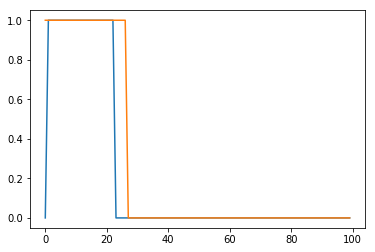

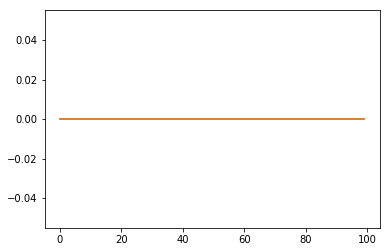

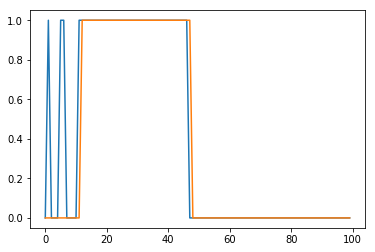

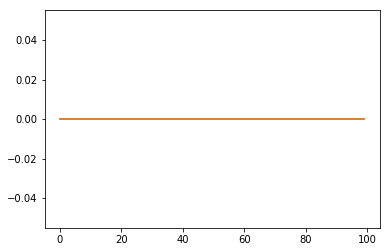

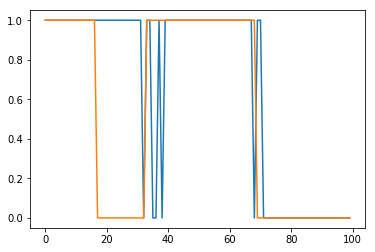

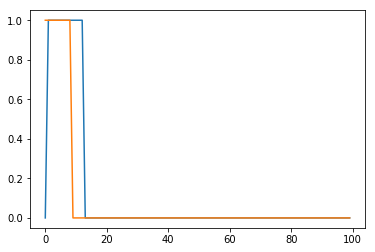

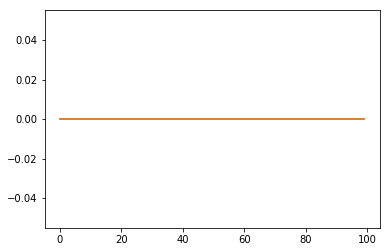

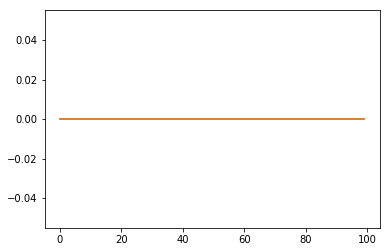

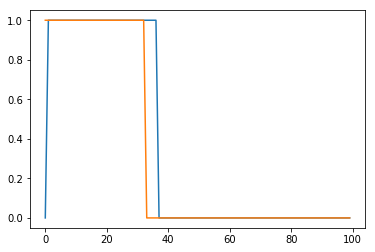

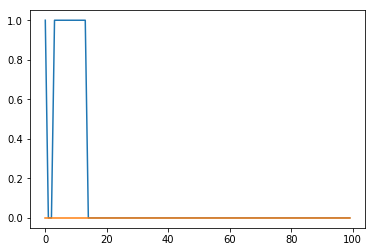

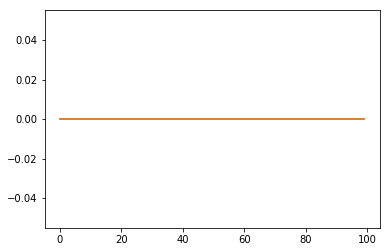

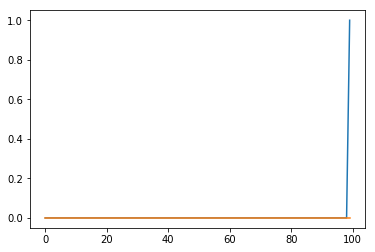

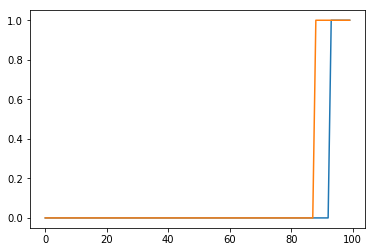

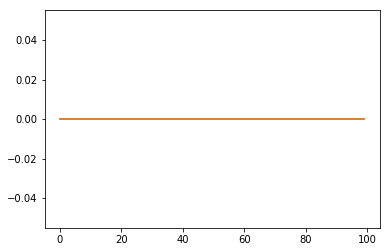

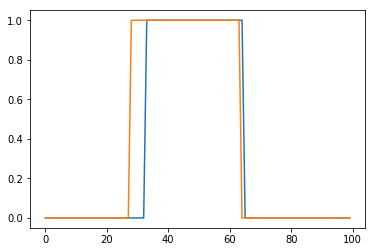

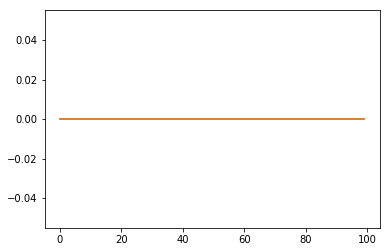

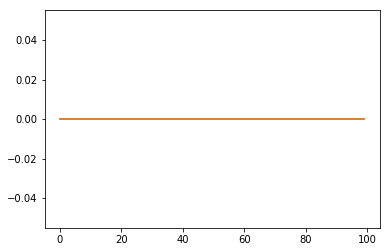

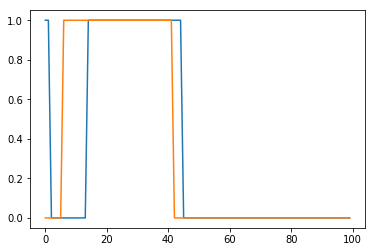

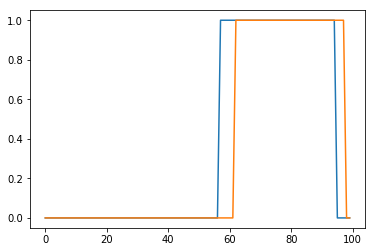

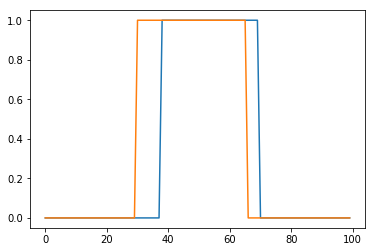

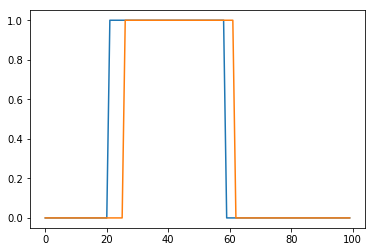

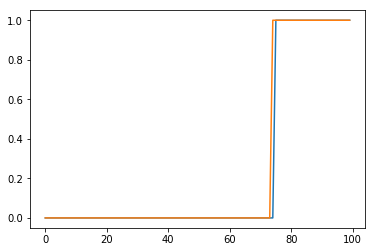

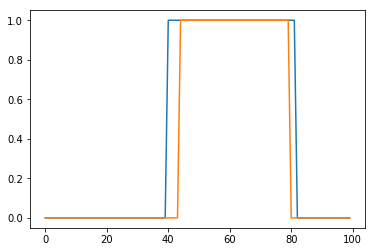

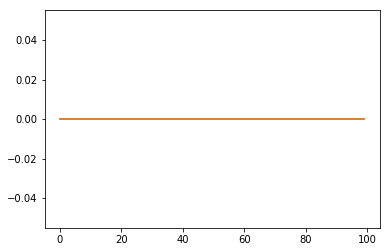

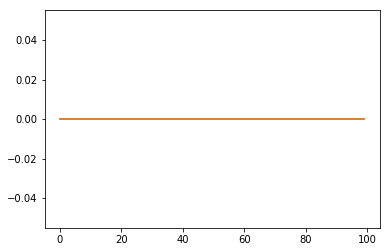

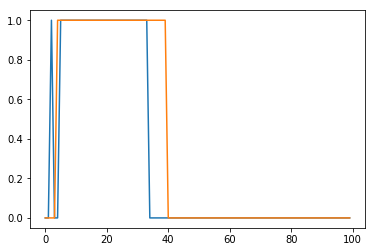

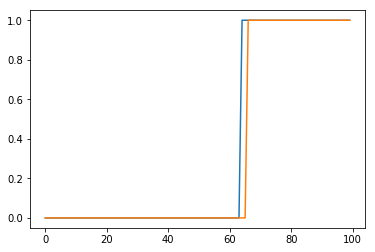

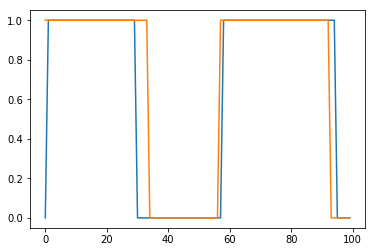

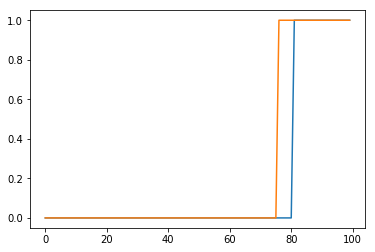

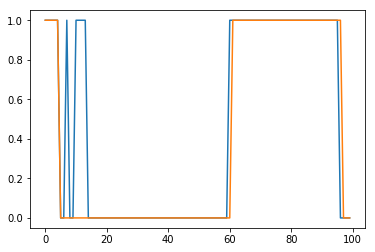

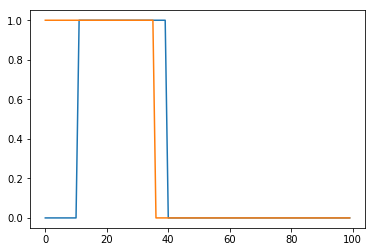

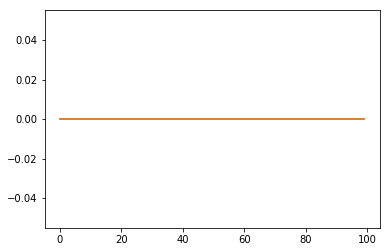

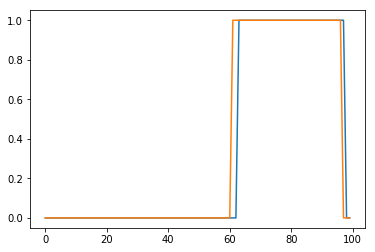

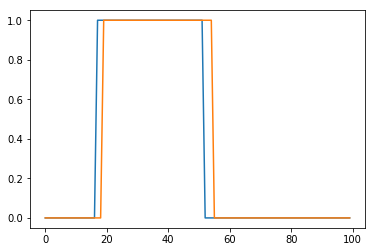

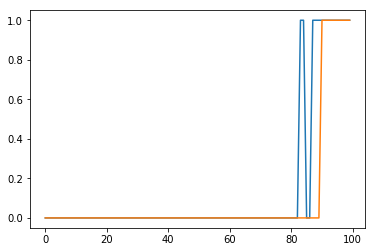

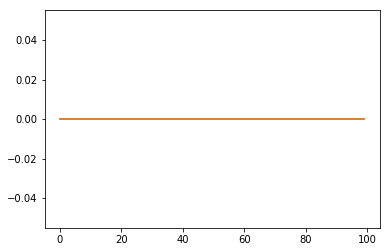

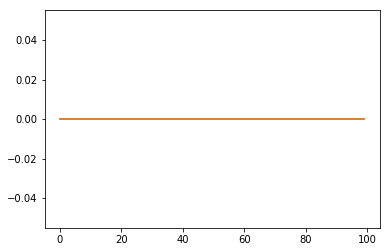

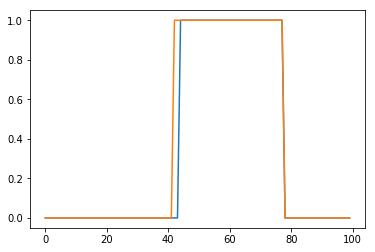

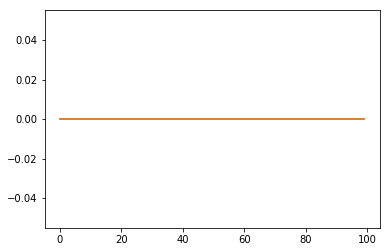

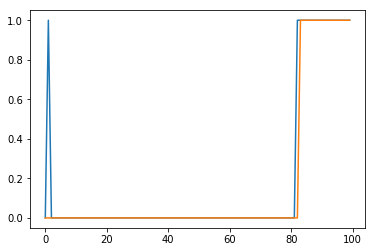

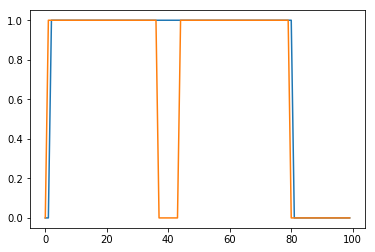

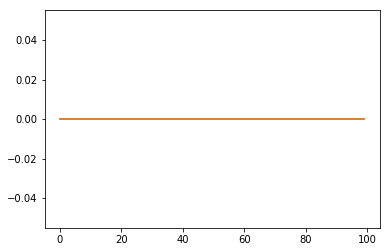

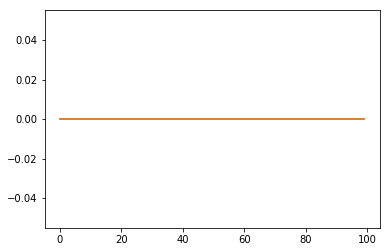

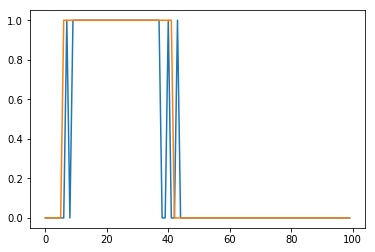

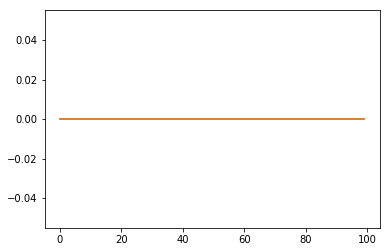

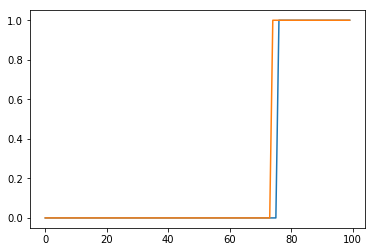

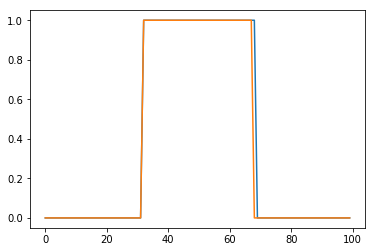

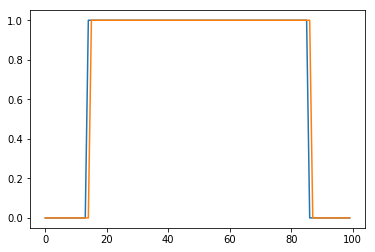

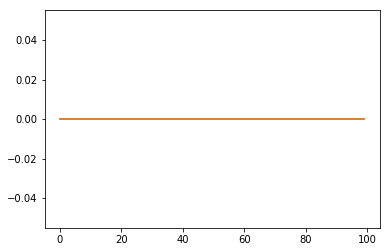

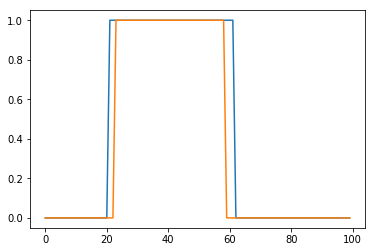

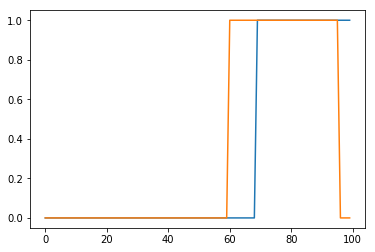

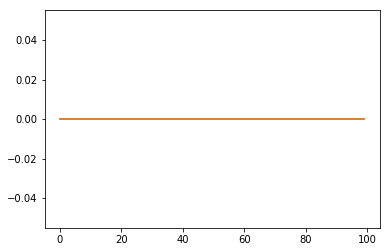

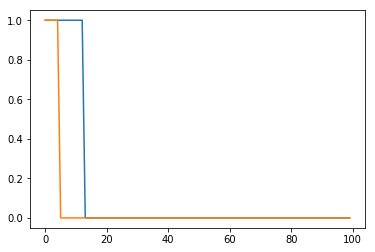

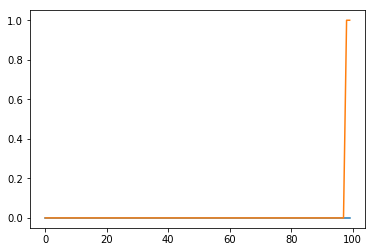

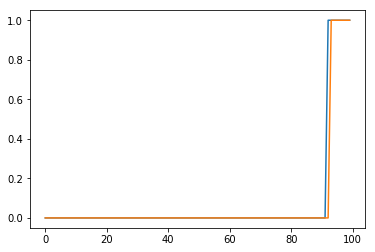

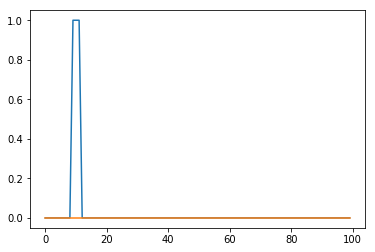

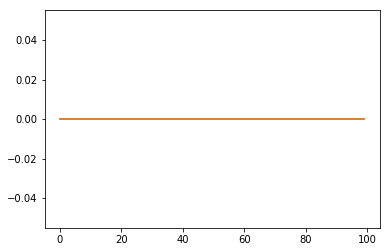

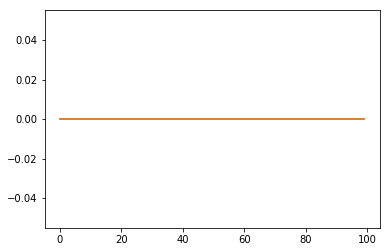

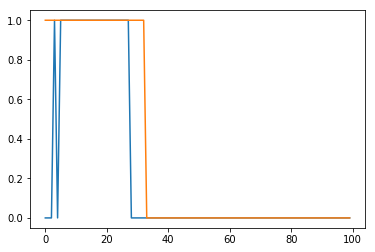

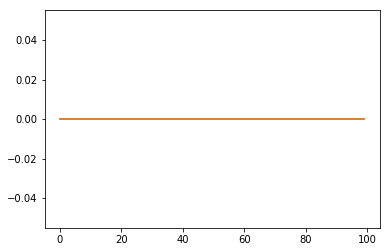

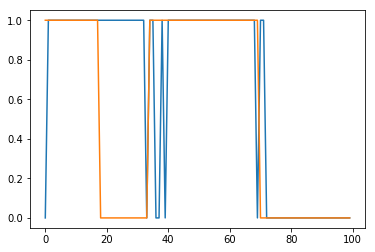

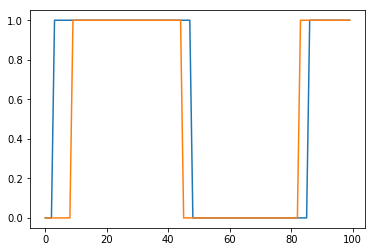

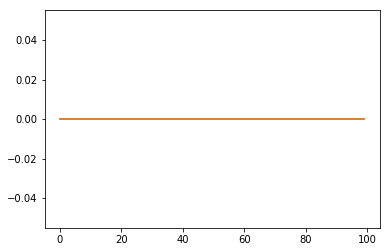

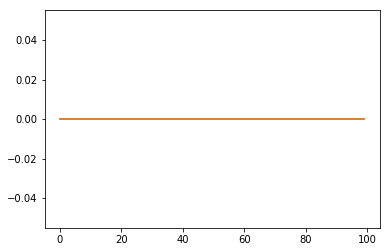

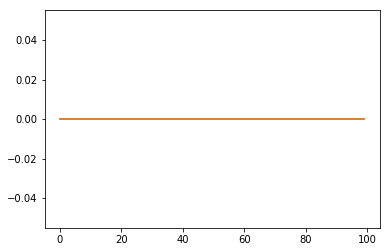

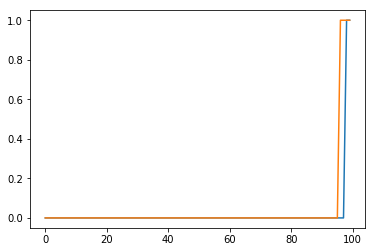

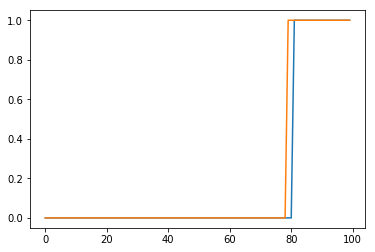

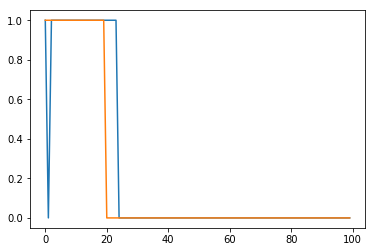

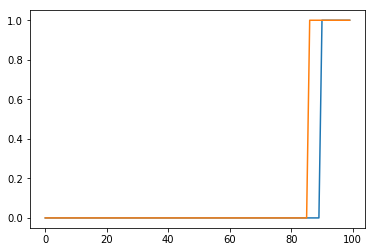

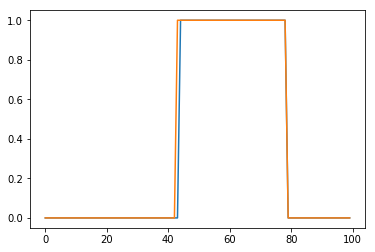

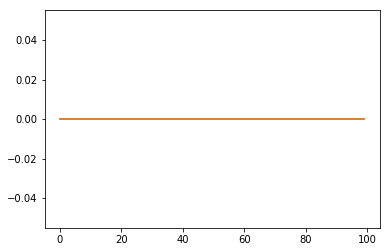

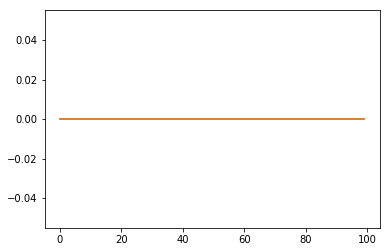

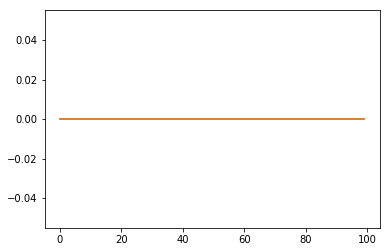

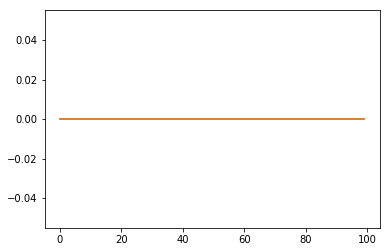

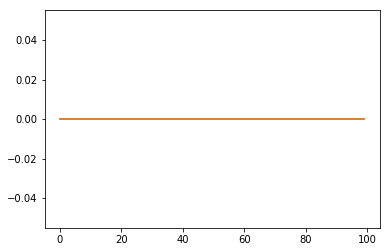

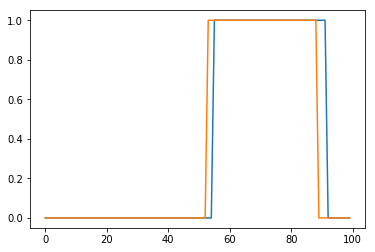

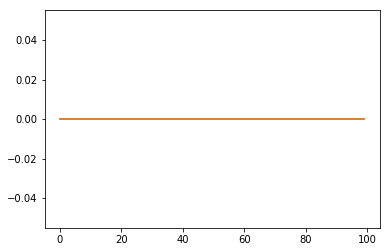

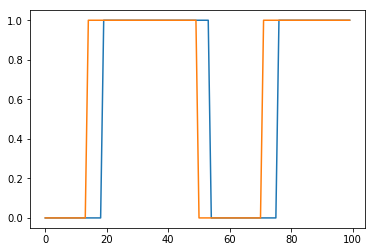

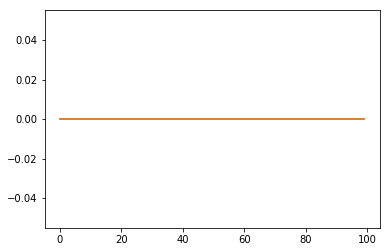

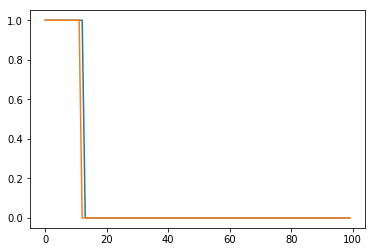

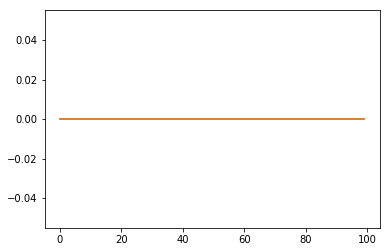

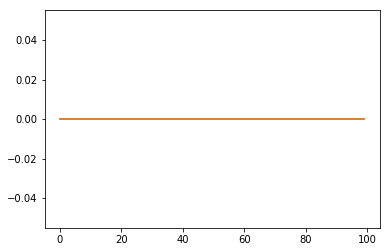

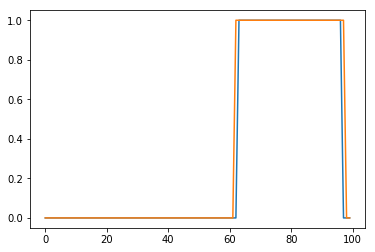

In [29]:
for i in range(res.shape[0]):
    plt.figure()
    plt.plot(np.argmax(res[i], axis=1))
    plt.plot(np.argmax(test_output[i], axis=1))
    plt.show()

In [25]:
np.argmax(res[8], axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
np.argmax(test_output[8], axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])